# 20 Newsgroups dataset - Semi_supervised classification
Xuekai Li

2025_april


In [8]:
# Standard library
import time
from collections import Counter, defaultdict, deque

# Third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import umap
import umap.plot
from imblearn.over_sampling import SMOTE
import nltk
from nltk.tokenize import word_tokenize

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Scikit-learn
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.svm import SVC

# Download NLTK tokenizer resources
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Dataset Preparation
#### vectiorize the text data

In [9]:
# Select 4 categories from the 20 Newsgroups dataset
categories = [
    'alt.atheism',
    'soc.religion.christian',
    'comp.graphics',
    'sci.med'
]

# Load the dataset with specified categories and remove headers, footers, and quotes
newsgroups = fetch_20newsgroups(
    subset='all',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

# Extract text data and labels
texts = newsgroups.data
labels = newsgroups.target
label_names = newsgroups.target_names

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=2,
    stop_words='english'
)
X = vectorizer.fit_transform(texts)


In [10]:
# Generate an array of label names for plotting
labels_with_name = np.array([label_names[label] for label in labels])
labels_with_name


array(['sci.med', 'soc.religion.christian', 'soc.religion.christian', ...,
       'sci.med', 'alt.atheism', 'sci.med'], dtype='<U22')

/var/folders/7f/tnlxqvzd3935f89h0dgn0vbm0000gn/T/ipykernel_73638/263923128.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels_with_name, palette='viridis')


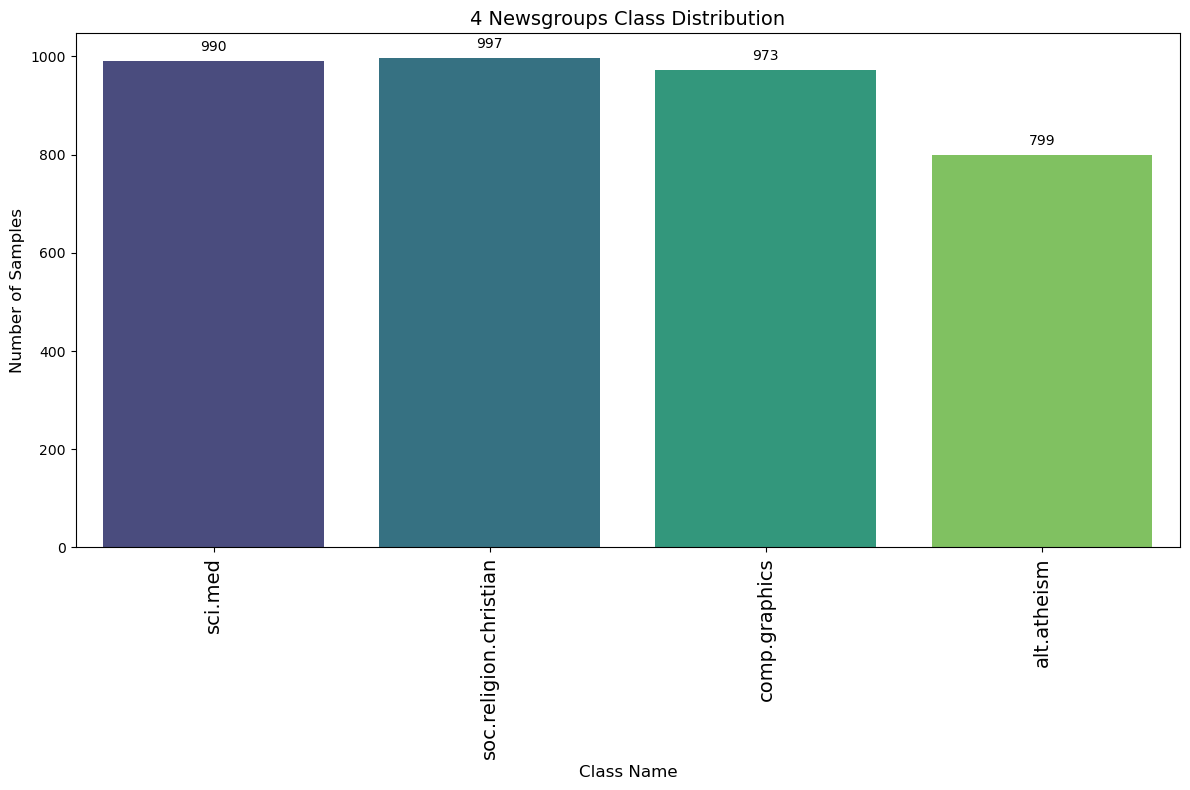

Counter({'soc.religion.christian': 997,
         'sci.med': 990,
         'comp.graphics': 973,
         'alt.atheism': 799})

In [11]:
def plot_labeled_counts(labels_with_name):
    """
    Creates a countplot with the integer number of samples displayed on each bar.

    Args:
        labels_with_name (array-like): A NumPy array or list of string labels.
    """
    plt.figure(figsize=(12, 8))
    ax = sns.countplot(x=labels_with_name, palette='viridis')

    # Add count labels to each bar
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}',
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha='center', va='center',
            xytext=(0, 10), textcoords='offset points'
        )

    # Customize plot appearance
    plt.xticks(rotation=90, fontsize=14)
    plt.xlabel('Class Name', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    plt.title('4 Newsgroups Class Distribution', fontsize=14)
    plt.tight_layout()
    plt.show()


# Plot class distribution
plot_labeled_counts(labels_with_name)

# Count the number of samples in each class
Counter(labels_with_name)


In [12]:
# Create a DataFrame for better visualization
df = pd.DataFrame({'text': texts, 'label': labels_with_name})
df.head(5)

,text,label
0,\nWhere did you read this? I don't think this...,sci.med
1,[Someone quoted the following. I've removed t...,soc.religion.christian
2,\n,soc.religion.christian
3,I've been away for a couple of weeks and have ...,comp.graphics
4,FYI...I just posted this on alt.psychoactives ...,sci.med


In [13]:
# Function to count tokens in a text sample
def count_tokens(text):
    """
    Tokenizes the input text and returns the number of tokens.

    Args:
        text (str): The input text to tokenize.

    Returns:
        int: The number of tokens in the text.
    """
    tokens = word_tokenize(text)
    return len(tokens)

# Apply token counting to the text column
min_tokens = df['text'].apply(count_tokens).min()
max_tokens = df['text'].apply(count_tokens).max()

print(f"Minimum token count: {min_tokens}")
print(f"Maximum token count: {max_tokens}")

Minimum token count: 0
Maximum token count: 11236


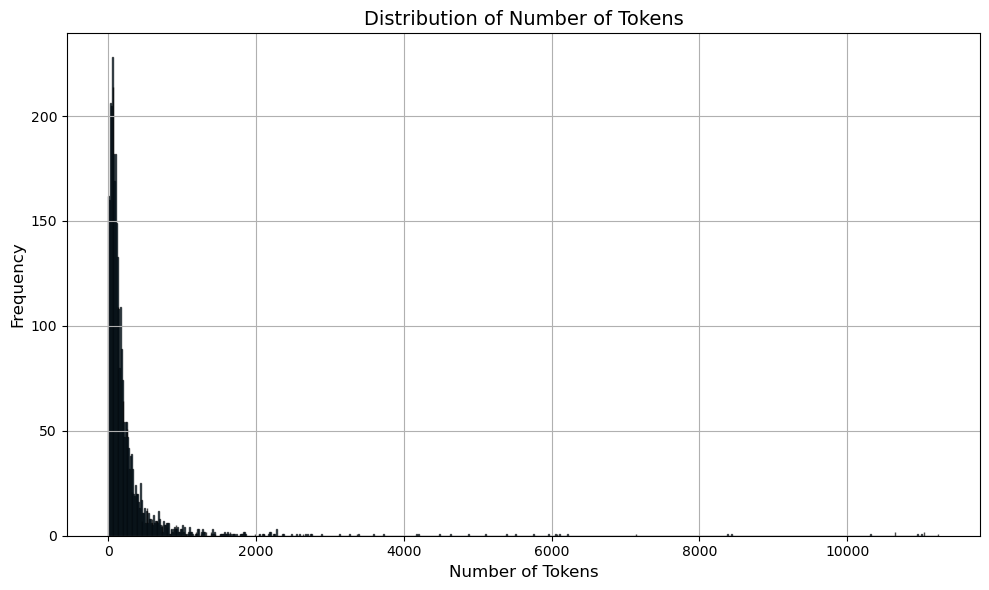

In [14]:
# Plot the distribution of token counts per document
plt.figure(figsize=(10, 6))
plt.hist(
    df['text'].apply(count_tokens),
    bins=1000,
    edgecolor='black',
    alpha=0.7
)
plt.title('Distribution of Number of Tokens', fontsize=14)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Display descriptive statistics of token counts per document
token_stats = df['text'].apply(count_tokens).describe()
print(token_stats)


count     3759.000000
mean       267.235967
std        707.662583
min          0.000000
25%         55.000000
50%        115.000000
75%        243.000000
max      11236.000000
Name: text, dtype: float64


### dimension reduction

/Users/kai/miniconda3/envs/np1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/kai/miniconda3/envs/np1/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


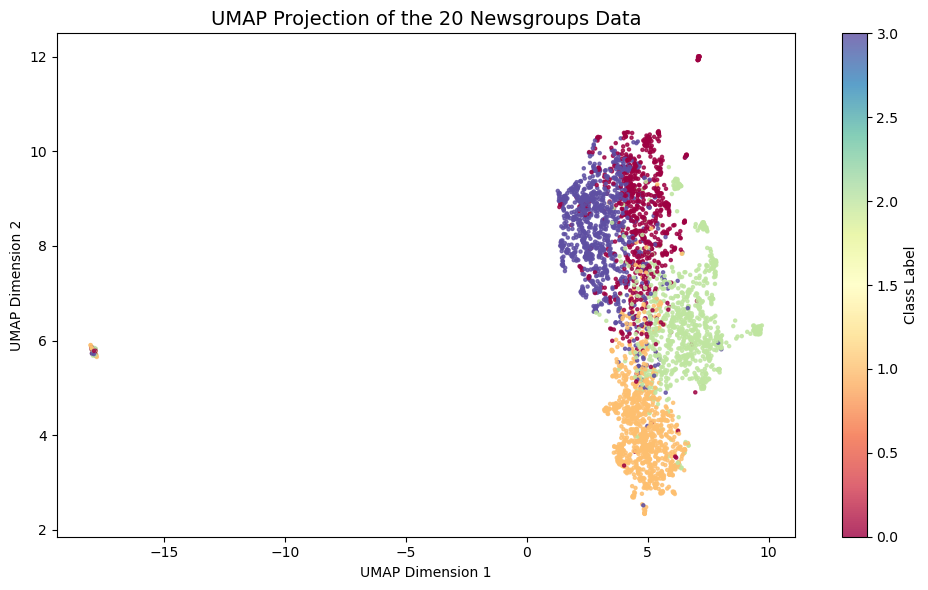

In [16]:
# Reduce high-dimensional TF-IDF features to 2D for visualization
mapper = umap.UMAP(metric='hellinger', random_state=42)
X_2d = mapper.fit_transform(X)

# Plot the 2D projection with color-coded classes
plt.figure(figsize=(10, 6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap='Spectral',
    s=5,
    alpha=0.8
)
plt.colorbar(label='Class Label')
plt.title('UMAP Projection of the 20 Newsgroups Data', fontsize=14)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.tight_layout()
plt.show()


### splite the dataset


In [17]:
# Normalize the UMAP-reduced data
scaler = StandardScaler()
X_2d = scaler.fit_transform(X_2d)

# Split into train and test sets (stratified)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_2d, labels, test_size=0.2, stratify=labels, random_state=42
)

# Split off unlabeled data from training set
X_unlabeled, X_temp, y_unlabeled, y_temp = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# Split the remaining into validation and training sets
X_validation, X_train, y_validation, y_train = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Print dataset sizes
print(f"Train set:      {X_train.shape[0]} samples")
print(f"Validation set: {X_validation.shape[0]} samples")
print(f"Unlabeled set:  {X_unlabeled.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")
print(f"Feature count:  {X_train_full.shape[1]} per sample")


Train set:      301 samples
Validation set: 301 samples
Unlabeled set:  2405 samples
Test set:       752 samples
Feature count:  2 per sample


### smote oversampling the imbalanced 

In [18]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Compare class distributions before and after SMOTE
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE: ", Counter(y_resampled))

# Show dataset shapes
print(f"X_train shape before SMOTE:   {X_train.shape}")
print(f"X_train shape after SMOTE:    {X_resampled.shape}")
print(f"X_test shape:                 {X_test.shape}")
print(f"X_validation shape:           {X_validation.shape}")
print(f"X_unlabeled shape:            {X_unlabeled.shape}")


Class distribution before SMOTE: Counter({3: 80, 2: 79, 1: 78, 0: 64})
Class distribution after SMOTE:  Counter({3: 80, 2: 80, 1: 80, 0: 80})
X_train shape before SMOTE:   (301, 2)
X_train shape after SMOTE:    (320, 2)
X_test shape:                 (752, 2)
X_validation shape:           (301, 2)
X_unlabeled shape:            (2405, 2)


## Classification set up (supervised and co-training)

In [19]:
# Initialize classifiers: K-Nearest Neighbors and Support Vector Machine
clf_knn = KNeighborsClassifier(
    n_neighbors=10,
    metric='cosine',
    weights='uniform'
)

clf_svm = SVC(
    kernel='rbf',
    probability=True,
    tol=1e-4,
    max_iter=10000,
    C=1.0
)

# Store classifiers in a list for iteration
classifiers = [clf_knn, clf_svm]


In [20]:
# Train initial classifiers on resampled labeled data
clf_knn.fit(X_resampled, y_resampled)
clf_svm.fit(X_resampled, y_resampled)

# Print F1 scores on resampled training data
print(f"KNN F1 (train): {f1_score(y_resampled, clf_knn.predict(X_resampled), average='macro')}")
print(f"SVM F1 (train): {f1_score(y_resampled, clf_svm.predict(X_resampled), average='macro')}")

# Evaluate on test set
f1_knn = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn = f1_score(y_test, clf_knn.predict(X_test), average='micro')
f1_micro_svm = f1_score(y_test, clf_svm.predict(X_test), average='micro')

# Set up co-training
X_cotrain = X_unlabeled.copy()

# Calculate confidence threshold from validation performance
confidence_threshold = (
    f1_score(y_validation, clf_knn.predict(X_validation), average='macro') +
    f1_score(y_validation, clf_svm.predict(X_validation), average='macro')
) / 2.0

# Get probability estimates and confidence scores
proba_knn = clf_knn.predict_proba(X_cotrain)
confidence_knn = np.max(proba_knn, axis=1)
labels_knn = np.argmax(proba_knn, axis=1)

proba_svm = clf_svm.predict_proba(X_cotrain)
confidence_svm = np.max(proba_svm, axis=1)
labels_svm = np.argmax(proba_svm, axis=1)

# Select high-confidence predictions (based on percentile threshold)
high_conf_knn = confidence_knn > np.percentile(confidence_knn, confidence_threshold * 100)
high_conf_svm = confidence_svm > np.percentile(confidence_svm, confidence_threshold * 100)

knn_indices = np.where(high_conf_knn)[0]
svm_indices = np.where(high_conf_svm)[0]
print(f"High-confidence samples: KNN={len(knn_indices)}, SVM={len(svm_indices)}")

# Pseudo-labeling
X_knn_add, y_knn_add = X_cotrain[svm_indices], labels_svm[svm_indices]
X_svm_add, y_svm_add = X_cotrain[knn_indices], labels_knn[knn_indices]

# Augment labeled datasets
X_labeled_knn = np.vstack([X_resampled, X_knn_add])
y_labeled_knn = np.hstack([y_resampled, y_knn_add])

X_labeled_svm = np.vstack([X_resampled, X_svm_add])
y_labeled_svm = np.hstack([y_resampled, y_svm_add])

# Retrain classifiers on augmented data
clf_knn.fit(X_labeled_knn, y_labeled_knn)
clf_svm.fit(X_labeled_svm, y_labeled_svm)

# Weight classifiers by validation F1
classifier_weights = np.array([
    f1_score(y_validation, clf.predict(X_validation), average='weighted')
    for clf in [clf_knn, clf_svm]
])
classifier_weights += 1e-6  # Avoid zero
classifier_weights /= classifier_weights.sum()

print("Classifier weights:", classifier_weights)

# Combine predictions using weighted average of probabilities
combined_probabilities = np.average(
    [clf.predict_proba(X_test) for clf in [clf_knn, clf_svm]],
    axis=0,
    weights=classifier_weights
)
combined_predictions = np.argmax(combined_probabilities, axis=1)

# Final evaluation
co_f1_macro = f1_score(y_test, combined_predictions, average='macro')
co_f1_micro = f1_score(y_test, combined_predictions, average='micro')

# Individual classifier scores after co-training
f1_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='macro')
f1_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='macro')
f1_micro_knn_co = f1_score(y_test, clf_knn.predict(X_test), average='micro')
f1_micro_svm_co = f1_score(y_test, clf_svm.predict(X_test), average='micro')

# Print pre- and post-co-training scores
print(f"Before Co-training - KNN Macro F1: {f1_knn}")
print(f"After Co-training  - KNN Macro F1: {f1_knn_co}")
print("-" * 40)
print(f"Before Co-training - SVM Macro F1: {f1_svm}")
print(f"After Co-training  - SVM Macro F1: {f1_svm_co}")
print("-" * 40)
print(f"Before Co-training - KNN Micro F1: {f1_micro_knn}")
print(f"After Co-training  - KNN Micro F1: {f1_micro_knn_co}")
print("-" * 40)
print(f"Before Co-training - SVM Micro F1: {f1_micro_svm}")
print(f"After Co-training  - SVM Micro F1: {f1_micro_svm_co}")
print("-" * 40)
print(f"Co-training Macro F1: {co_f1_macro}")
print(f"Co-training Micro F1: {co_f1_micro}")


KNN F1 (train): 0.7928455911413879
SVM F1 (train): 0.8006856791299515
High-confidence samples: KNN=517, SVM=518
Classifier weights: [0.49903006 0.50096994]
Before Co-training - KNN Macro F1: 0.8343711811566086
After Co-training  - KNN Macro F1: 0.8343711811566086
----------------------------------------
Before Co-training - SVM Macro F1: 0.833424027341126
After Co-training  - SVM Macro F1: 0.8362305118837943
----------------------------------------
Before Co-training - KNN Micro F1: 0.839095744680851
After Co-training  - KNN Micro F1: 0.839095744680851
----------------------------------------
Before Co-training - SVM Micro F1: 0.836436170212766
After Co-training  - SVM Micro F1: 0.8404255319148937
----------------------------------------
Co-training Macro F1: 0.8438341456130249
Co-training Micro F1: 0.848404255319149


## CORL_ENV difination

In [21]:
class Env:
    def __init__(self, classifiers, input_ul_data, k, X_test, y_test, X_reset, y_reset, window_size=10):
        """
        Environment for co-training-based semi-supervised learning.

        Args:
            classifiers (list): List of two classifier models (e.g., [knn, svm]).
            input_ul_data (ndarray): Unlabeled data to be clustered.
            k (int): Number of clusters.
            X_test (ndarray): Evaluation data features.
            y_test (ndarray): Evaluation data labels.
            X_reset (ndarray): Labeled data used for resetting models.
            y_reset (ndarray): Corresponding labels for X_reset.
            window_size (int): Size of rolling window for baseline F1 difference.
        """
        self.models = classifiers
        self.X_ul = input_ul_data
        self.X_eval = X_test
        self.y_eval = y_test
        self.X_reset = X_reset
        self.y_reset = y_reset
        self.action_size = k
        self.window_size = window_size

        # Cluster the unlabeled data
        self.agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
        self.cluster_label = self.agglo.fit_predict(self.X_ul)
        self.u_cluster_label = np.unique(self.cluster_label)
        self.centroids = np.array([
            self.X_ul[self.cluster_label == i].mean(axis=0)
            for i in self.u_cluster_label
        ])

        self.observation_size = self.get_state(reset=True).shape[1]
        self.prev_macro_f1 = 0.0
        self.f1_diff_history = deque(maxlen=window_size)

    def train_2_clf(self, X, y):
        self.models[0].fit(X, y)
        self.models[1].fit(X, y)

    def get_state(self, reset=False):
        if reset:
            if self.X_reset is not None and self.y_reset is not None:
                self.train_2_clf(self.X_reset, self.y_reset)
            else:
                raise ValueError("Reset datasets (X_reset or y_reset) are missing.")

        try:
            out_1 = self.models[0].predict_proba(self.centroids)
            out_2 = self.models[1].predict_proba(self.centroids)
        except Exception as e:
            raise RuntimeError("Model prediction failed: " + str(e))

        state_proba = np.concatenate((out_1, out_2), axis=1)
        return torch.from_numpy(state_proba).float().reshape(1, -1)

    def get_f1(self, X_eval=None, y_eval=None):
        X_eval = X_eval if X_eval is not None else self.X_eval
        y_eval = y_eval if y_eval is not None else self.y_eval

        classifier_weights = np.array([
            f1_score(y_eval, clf.predict(X_eval), average='weighted')
            for clf in self.models
        ])
        classifier_weights += 1e-6  # Prevent division by zero
        classifier_weights /= classifier_weights.sum()

        combined_probabilities = np.average(
            [clf.predict_proba(X_eval) for clf in self.models],
            axis=0,
            weights=classifier_weights
        )
        combined_predictions = np.argmax(combined_probabilities, axis=1)

        return (
            f1_score(y_eval, combined_predictions, average='macro'),
            f1_score(y_eval, combined_predictions, average='micro'),
            f1_score(y_eval, combined_predictions, average='weighted')
        )

    def get_subset(self, action):
        return self.X_ul[self.cluster_label == action]

    def co_training(self, subset):
        # Estimate confidence threshold based on current validation performance
        confidence_threshold = (
            f1_score(self.y_eval, self.models[0].predict(self.X_eval), average='macro') +
            f1_score(self.y_eval, self.models[1].predict(self.X_eval), average='macro')
        ) / 2.0

        proba_knn = self.models[0].predict_proba(subset)
        proba_svm = self.models[1].predict_proba(subset)

        confidence_knn = np.max(proba_knn, axis=1)
        labels_knn = np.argmax(proba_knn, axis=1)

        confidence_svm = np.max(proba_svm, axis=1)
        labels_svm = np.argmax(proba_svm, axis=1)

        high_conf_knn = confidence_knn > np.percentile(confidence_knn, confidence_threshold * 100)
        high_conf_svm = confidence_svm > np.percentile(confidence_svm, confidence_threshold * 100)

        knn_indices = np.where(high_conf_knn)[0]
        svm_indices = np.where(high_conf_svm)[0]

        X_knn_add, y_knn_add = subset[svm_indices], labels_svm[svm_indices]
        X_svm_add, y_svm_add = subset[knn_indices], labels_knn[knn_indices]

        X_labeled_knn = np.vstack([self.X_reset, X_knn_add])
        y_labeled_knn = np.hstack([self.y_reset, y_knn_add])

        X_labeled_svm = np.vstack([self.X_reset, X_svm_add])
        y_labeled_svm = np.hstack([self.y_reset, y_svm_add])

        self.models[0].fit(X_labeled_knn, y_labeled_knn)
        self.models[1].fit(X_labeled_svm, y_labeled_svm)

        return self.get_f1()

    def step(self, action):
        # Save current state performance
        macro_f1_old, micro_f1_old, weighted_f1_old = self.get_f1()

        # Select and co-train on the chosen subset
        subset = self.get_subset(action)
        macro_f1_new, micro_f1_new, weighted_f1_new = self.co_training(subset)

        # Get the new state
        new_state = self.get_state()

        # Compute reward using baseline F1 improvement
        f1_diff = macro_f1_new - macro_f1_old
        self.f1_diff_history.append(f1_diff)

        baseline = np.mean(self.f1_diff_history) if self.f1_diff_history else f1_diff
        reward = f1_diff - baseline

        return new_state, reward, macro_f1_new, micro_f1_new, weighted_f1_new


### FOR INSTANCE set up the RLCO ENV

In [22]:
# Initialize co-training environment
k = 17
env = Env(
    classifiers=classifiers,
    input_ul_data=X_unlabeled,
    k=k,
    X_test=X_validation,
    y_test=y_validation,
    X_reset=X_resampled,
    y_reset=y_resampled
)

# Evaluate initial combined classifier performance
env.get_f1()

# Optional: retrieve a cluster subset
# env.get_subset(2)


(0.7889973030837587, 0.7940199335548173, 0.7926199657850261)

### RL-AC network setting up

In [23]:
# Actor-Critic Neural Network for Policy Gradient RL
class ActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(ActorCritic, self).__init__()

        # Shared layers
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)

        # Actor head: outputs action probabilities
        self.actor = nn.Linear(128, action_size)

        # Critic head: outputs scalar value for the state
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        # Actor: softmax output over action logits
        action_probs = torch.softmax(self.actor(x), dim=-1)

        # Critic: state value estimate
        state_value = self.critic(x)

        return action_probs, state_value


In [24]:
# Initialize Actor-Critic network and optimizer
actor_critic = ActorCritic(env.observation_size, env.action_size)
optimizer = optim.Adam(actor_critic.parameters(), lr=0.001)

# Training hyperparameters
num_episodes = 200
gamma = 0.99  # Discount factor

# Tracking metrics during training
episode_rewards = []
episode_f1 = []
macro_f1_scores = []
micro_f1_scores = []


## RL-Cotraining

In [25]:
# Main training loop
for episode in tqdm(range(num_episodes)):
    state = env.get_state(reset=True)
    episode_reward = 0

    for t in range(1, 200):  # Limit episode length
        # Forward pass through Actor-Critic
        action_probs, state_value = actor_critic(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()

        # Environment step
        next_state, reward, macro_f1, micro_f1, weighted_f1 = env.step(action.item())
        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Compute advantage
        _, next_state_value = actor_critic(next_state)
        advantage = reward + gamma * next_state_value - state_value

        # Loss functions
        actor_loss = -dist.log_prob(action) * advantage.detach()
        critic_loss = advantage.pow(2)
        total_loss = actor_loss + critic_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Update state
        state = next_state
        episode_reward += reward
        episode_f1.append(macro_f1)

        # Track macro/micro scores for the last episode
        if episode == num_episodes - 1:
            macro_f1_scores.append(macro_f1)
            micro_f1_scores.append(micro_f1)

    # Track cumulative reward for this episode
    episode_rewards.append(episode_reward)

    # Logging every 10 episodes
    if episode % 10 == 0:
        print(f"Episode {episode}, Reward: {episode_reward:.4f}")


  0%|          | 0/200 [00:00<?, ?it/s]

Episode 0, Reward: -0.0003
Episode 10, Reward: -0.0000
Episode 20, Reward: -0.0000
Episode 30, Reward: 0.0004
Episode 40, Reward: 0.0000
Episode 50, Reward: 0.0007
Episode 60, Reward: 0.0001
Episode 70, Reward: -0.0000
Episode 80, Reward: -0.0003
Episode 90, Reward: 0.0013
Episode 100, Reward: 0.0000
Episode 110, Reward: -0.0017
Episode 120, Reward: -0.0000
Episode 130, Reward: -0.0001
Episode 140, Reward: 0.0000
Episode 150, Reward: 0.0000
Episode 160, Reward: 0.0031
Episode 170, Reward: 0.0008
Episode 180, Reward: -0.0006
Episode 190, Reward: -0.0032


In [26]:
# Evaluate final performance of the RL-enhanced co-training system
corl_f1_macro, corl_f1_micro, _ = env.get_f1(X_eval=X_test, y_eval=y_test)

# Print F1 scores for the combined classifier (coRL)
print(f"RL Co-training Combined F1 Macro: {corl_f1_macro:.4f}")
print(f"RL Co-training Combined F1 Micro: {corl_f1_micro:.4f}")


RL Co-training Combined F1 Macro: 0.8399
RL Co-training Combined F1 Micro: 0.8444


### Plot the dynamic learning.

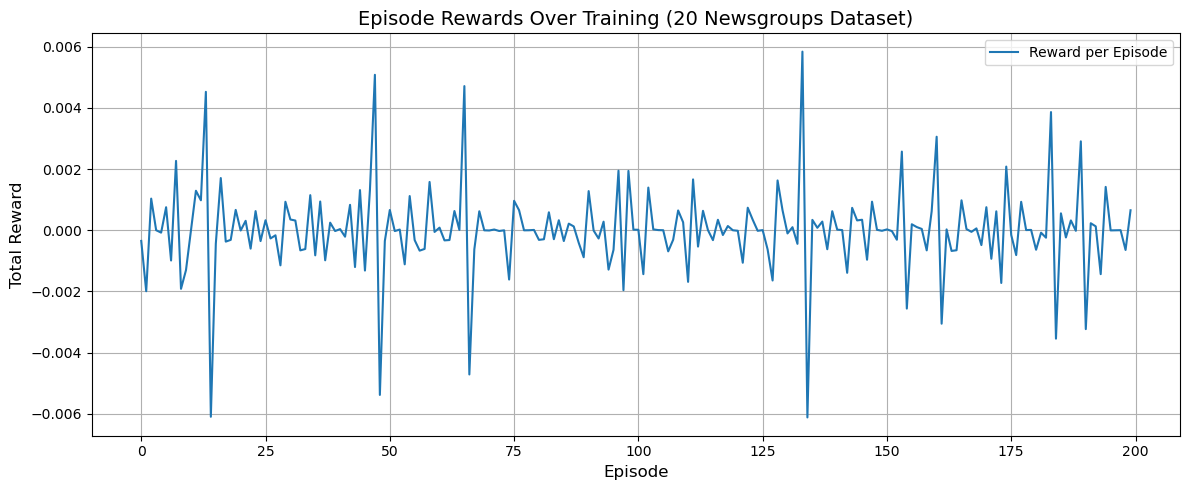

In [27]:
# Plot: Episode rewards over training (Actor-Critic on 20 Newsgroups)
plt.figure(figsize=(12, 5))
plt.plot(episode_rewards, label="Reward per Episode")
plt.title("Episode Rewards Over Training (20 Newsgroups Dataset)", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


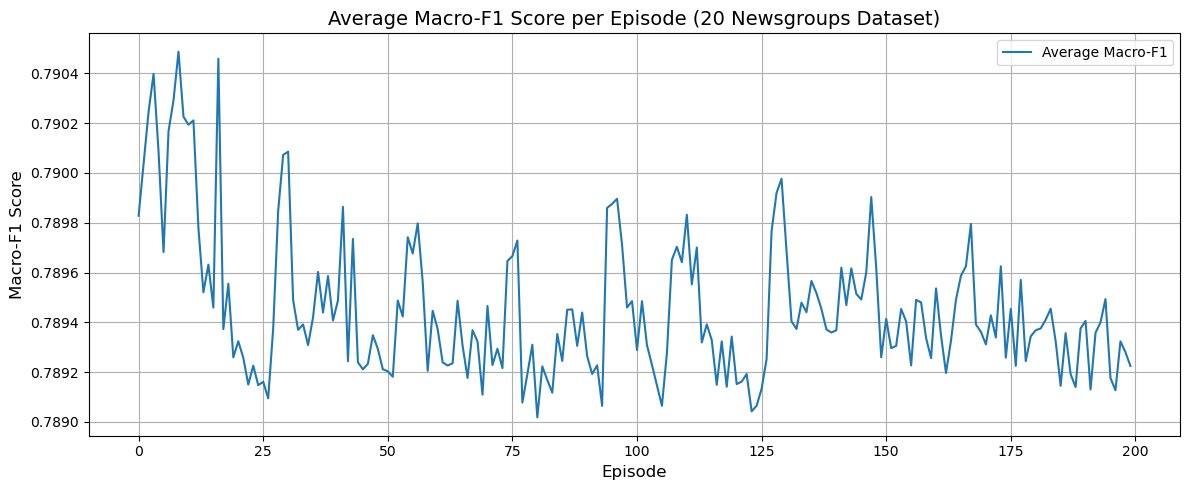

In [28]:
# Plot: Average Macro-F1 Score per Episode
# Each episode has 199 steps (t from 1 to 199)
steps_per_episode = 199
f1_matrix = np.array(episode_f1).reshape(-1, steps_per_episode)

# Compute average F1 per episode
avg_f1_per_episode = f1_matrix.mean(axis=1)

plt.figure(figsize=(12, 5))
plt.plot(avg_f1_per_episode, label="Average Macro-F1")
plt.title("Average Macro-F1 Score per Episode (20 Newsgroups Dataset)", fontsize=14)
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Macro-F1 Score", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


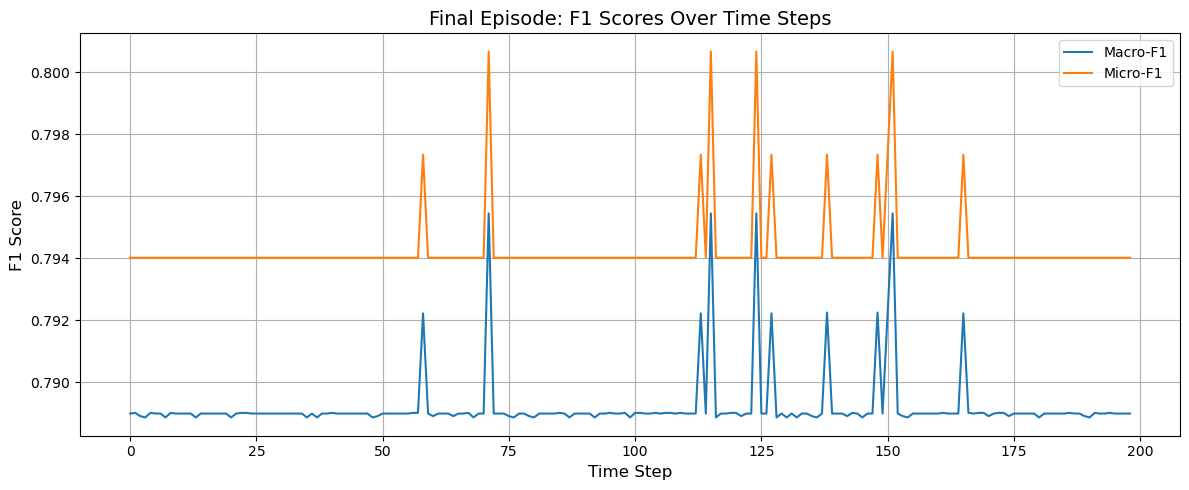

In [29]:
# Plot: Final Episode Performance (Macro & Micro F1 scores)
plt.figure(figsize=(12, 5))
plt.plot(macro_f1_scores, label="Macro-F1")
plt.plot(micro_f1_scores, label="Micro-F1")
plt.title("Final Episode: F1 Scores Over Time Steps", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("F1 Score", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
